# Treinar modelo de recuperação

In [1]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import zipfile

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

'pt_BR.utf8'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path = env)


print("Iniciando carregamento dos dados")
zip_file = os.path.join(dataPath, 'base_treino.zip')
z = zipfile.ZipFile(zip_file)

Iniciando carregamento dos dados


# 00) Auxiliar

In [4]:
def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

def cria_chave(row):
    return str(row['cda']) + ' - ' + str(row['id_pessoa'])

def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

def ler_bases_exportadas(nome_arquivo):
    z.extract(nome_arquivo)
    df = pd.read_csv(nome_arquivo, sep=',')
    os.remove(nome_arquivo)
    return df

# 01) Importando dados

In [5]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [18]:
dados_divida = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_divida_prime_2.csv')

In [19]:
df = dados_divida[dados_divida['id_pessoa'] == '000032f6d93a0abd']
df

,cda,id_pessoa,tipo_divida,valor_total_da,vlr_pago,protesto,ajuizamento,inscricao_divida,quantidade_reparcelamento,idade_divida,ano_inscricao_da,mes_inscricao_da,percentual_pago_cda
160617,11249d8bbe8521a89989bae6f4af91ee2,000032f6d93a0abd,mercantil,8386.99,0.00,0,1,2012-09-15,0,11.0,2012,9,0.000000
229281,18663a5f9b33c3ad9fcacff532cf50c42,000032f6d93a0abd,mercantil,5954.64,0.00,0,0,2017-05-27 00:00:00,0,6.0,2017,5,0.000000
728422,4d569276447013089fcacff532cf50c42,000032f6d93a0abd,mercantil,10529.50,0.00,0,1,2014-10-25,0,9.0,2014,10,0.000000
825643,5798154ce40edf871,000032f6d93a0abd,imovel,5404.26,1422.52,0,1,2006-01-31,1,18.0,2006,1,0.263222
1243895,83e8a51f206397736b3a8e268c80aedf2,000032f6d93a0abd,mercantil,1096.59,0.00,0,0,2018-07-07,0,5.0,2018,7,0.000000
1347198,8ed62cf12b867b229ceed47545e621dd1,000032f6d93a0abd,imovel,7311.37,1916.79,0,1,2006-01-31,1,18.0,2006,1,0.262166
1678925,b208dd365dbb6b4c6b3a8e268c80aedf2,000032f6d93a0abd,mercantil,9769.89,0.00,0,1,1995-09-06,0,28.0,1995,9,0.000000
1682473,b269b3c8a08334b29fcacff532cf50c42,000032f6d93a0abd,mercantil,1897.32,0.00,0,0,2016-05-14,0,7.0,2016,5,0.000000
1808205,bfb98e5cd3a4eb2e7c8fa7a67092eaab2,000032f6d93a0abd,mercantil,7519.63,0.00,0,1,2011-10-16,0,12.0,2011,10,0.000000
2071595,db950944ce8b2b706b3a8e268c80aedf2,000032f6d93a0abd,mercantil,22147.06,0.00,0,1,1999-10-12,0,24.0,1999,10,0.000000


In [20]:
dados_contribuinte = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_contribuinte_prime_2.csv')

In [21]:
df2 = dados_contribuinte[dados_contribuinte['id_pessoa'] == '000032f6d93a0abd']
df2

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,deb_totais,deb_pagos,valor_tot,vlr_pago,qtd_notas_2anos,edificacao,...,cpf_cnpj_existe,perfil_acessivel,situacao_cobranca,class_situacao_cobranca,historico_pagamento_em_qtd,historico_pagamento_em_valor,class_contribuinte,class_contribuinte_nome,class_contribuinte_perfil,class_contribuinte_peso
120167,000032f6d93a0abd,imovel,2,2,10.0,8.0,12715.63,3339.31,0.0,1.0,...,1,2.0,3.0,MUITO ACESSÍVEL,0.8,0.262615,0,CONTRIB RAZOAVEL,CONTROLADO,0.84045
376989,000032f6d93a0abd,mercantil,9,0,66.0,0.0,69091.42,0.00,0.0,0.0,...,1,0.0,0.0,INACESSÍVEL,0.0,0.000000,4,CONTRIB PESSIMO,NÃO PAGA,-0.79044


In [ ]:
# # Quantidade de Reparcelamento por CDA
# base_conjunta = ler_bases_exportadas('imovel_mercantil.csv')
# reparc_por_cda = base_conjunta[['cda', 'quantidade_reparcelamento']]

# dados_divida = pd.merge(dados_divida, reparc_por_cda, on = 'cda', how = 'left')
# dados_divida

# 02) Processamento da feature store

In [22]:
print("Variáveis sobre as dívidas:")
print("\n", dados_divida.columns)

Variáveis sobre as dívidas:

 Index(['cda', 'id_pessoa', 'tipo_divida', 'valor_total_da', 'vlr_pago',
       'protesto', 'ajuizamento', 'inscricao_divida',
       'quantidade_reparcelamento', 'idade_divida', 'ano_inscricao_da',
       'mes_inscricao_da', 'percentual_pago_cda'],
      dtype='object')


In [23]:
print("Variáveis dos contribuintes:")
print("\n", dados_contribuinte.columns)

Variáveis dos contribuintes:

 Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'deb_totais', 'deb_pagos', 'valor_tot', 'vlr_pago', 'qtd_notas_2anos',
       'edificacao', 'situacao', 'cpf_cnpj_existe', 'perfil_acessivel',
       'situacao_cobranca', 'class_situacao_cobranca',
       'historico_pagamento_em_qtd', 'historico_pagamento_em_valor',
       'class_contribuinte', 'class_contribuinte_nome',
       'class_contribuinte_perfil', 'class_contribuinte_peso'],
      dtype='object')


In [24]:
# Filtrando variáveis de interesse para a modelagem
df_divida = dados_divida[['cda', 
                          'tipo_divida',
                          'id_pessoa', 
                          'percentual_pago_cda', 
                          'valor_total_da', 
                          'idade_divida', 
                          'quantidade_reparcelamento' 
                          ]] 


In [28]:
df_contribuinte = dados_contribuinte[['id_pessoa', 
                                      'tipo_divida',
                                      'num_dist_cda', 
                                      'quantidade_reparcelamento',
                                      'historico_pagamento_em_qtd',
                                       'historico_pagamento_em_valor',
                                       'situacao_cobranca',
                                          'class_contribuinte_peso']]
df_contribuinte = df_contribuinte.rename(columns = {'quantidade_reparcelamento':'total_reparc_contrib'})

In [29]:
df_divida['quantidade_reparcelamento'] = df_divida['quantidade_reparcelamento'].fillna(0)
df_divida

,cda,tipo_divida,id_pessoa,percentual_pago_cda,valor_total_da,idade_divida,quantidade_reparcelamento
0,00000123c3d4731c6b3a8e268c80aedf1,imovel,ac28642d7c82b33f,0.0,2048.73,1.0,0
1,00000123c3d4731c6b3a8e268c80aedf2,mercantil,fc4b99b807fbed41,0.0,2515.85,1.0,0
2,00000b44c5ba1e669ceed47545e621dd2,mercantil,96e8e553de69d7a4,0.0,1278.97,21.0,0
3,000014e359592e62d8a3e5cebc255ca6E,mercantil,6dbe14da38a31dc1,0.0,847.02,0.0,0
4,0000331f601a73e52b46f673bf0c61251,imovel,870c08c252b25ad1,0.0,344.12,11.0,0
...,...,...,...,...,...,...,...
2414893,ffffd8af5760cada9fcacff532cf50c41,imovel,d411f54ad97d1f39,0.0,1728.13,4.0,0
2414894,ffffdb721b90282718565e26094f06ee2,mercantil,51d6043a4efa1ed1,0.0,240.77,6.0,0
2414895,ffffdc78aa7a90e26b3a8e268c80aedf1,imovel,9b512f210b460120,0.0,9390.43,25.0,0
2414896,fffff192f894983c9ceed47545e621dd1,imovel,dd5538d2d38803a7,0.0,16594.80,15.0,0


In [30]:
df = pd.merge(left =df_divida, right=df_contribuinte, on=['id_pessoa', 'tipo_divida'])
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'quantidade_reparcelamento',
       'num_dist_cda', 'total_reparc_contrib', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'situacao_cobranca',
       'class_contribuinte_peso'],
      dtype='object')

In [31]:
# Métricas p acompanhar
num_cda_01 = df['cda'].nunique() # 2.414.898
num_pessoa_01 = df['id_pessoa'].nunique() # 424.059
vlr_da_01 = df['valor_total_da'].sum() # R$ 31.917.794.308,13

In [32]:
num_cda_01

2414898

In [33]:
num_pessoa_01

424059

In [34]:
vlr_da_01 = locale.currency(vlr_da_01, grouping=True)
vlr_da_01

'R$ 25.587.769.503,12'

In [35]:
df_prop_estoque = df.groupby(['tipo_divida'])['valor_total_da'].sum().to_frame().reset_index()
estoque_total = df_prop_estoque['valor_total_da'].sum()
df_prop_estoque['perc_da'] = np.round(df_prop_estoque['valor_total_da']/estoque_total, 5)


df_prop_estoque['valor_total_da'] = df_prop_estoque['valor_total_da'].apply(formatar_moeda)
df_prop_estoque

,tipo_divida,valor_total_da,perc_da
0,imovel,"R$ 11.118.551.656,63",0.43453
1,mercantil,"R$ 14.469.217.846,49",0.56547


In [36]:
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'quantidade_reparcelamento',
       'num_dist_cda', 'total_reparc_contrib', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'situacao_cobranca',
       'class_contribuinte_peso'],
      dtype='object')

In [37]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)
df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']

df['percentual_pago_cda_faixas'] = pd.cut(df['percentual_pago_cda'],
                                bins = igr_bins,
                                labels = igr_labels,
                                right = False)

In [38]:
df_metrics = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total = df_metrics['percentual_pago_cda_faixas'].sum()  
df_metrics['total'] = total
df_metrics['perc'] = np.round(df_metrics['percentual_pago_cda_faixas']/total, 4)
df_metrics

,percentual_pago_cda_faixas,total,perc
percentual_pago_cda_faixas,,,
"[0.0, 0.01)",1813571,2414897,0.7510
"[0.01, 0.25)",195947,2414897,0.0811
"[0.25, 0.5)",100324,2414897,0.0415
"[0.5, 0.75)",60223,2414897,0.0249
"[0.75, 0.99)",4113,2414897,0.0017
"[0.99, 1.0)",7,2414897,0.0000
"[1.0, 1.01)",240712,2414897,0.0997


# Filtrando os últimos 10 anos

In [39]:
df.shape[0] # 2.414.898

2414898

In [40]:
# Filtrando apenas dados recentes para treinamento
df = df.query("idade_divida < 10")

In [41]:
df.shape[0] # 1.411.568

1411568

In [42]:
df_metrics2 = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total2 = df_metrics2['percentual_pago_cda_faixas'].sum()  
df_metrics2['perc'] = np.round(df_metrics2['percentual_pago_cda_faixas']/total2, 4)
df_metrics2

,percentual_pago_cda_faixas,perc
percentual_pago_cda_faixas,,
"[0.0, 0.01)",1095323,0.7760
"[0.01, 0.25)",94033,0.0666
"[0.25, 0.5)",34839,0.0247
"[0.5, 0.75)",38711,0.0274
"[0.75, 0.99)",2366,0.0017
"[0.99, 1.0)",2,0.0000
"[1.0, 1.01)",146294,0.1036


In [43]:
# Estoque considerando os últimos 10 anos
est_10anos = df['valor_total_da'].sum()
est_10anos = locale.currency(est_10anos, grouping=True)
est_10anos

'R$ 8.487.960.475,44'

In [44]:
# Retirando variáveis que não serão usadas no modelo
df_feature_store = df.drop(columns=['cda', 'id_pessoa'])

In [45]:
df_feature_store.isnull().sum()

tipo_divida                     0
percentual_pago_cda             0
valor_total_da                  0
idade_divida                    0
quantidade_reparcelamento       0
num_dist_cda                    0
total_reparc_contrib            0
historico_pagamento_em_qtd      0
historico_pagamento_em_valor    0
situacao_cobranca               0
class_contribuinte_peso         0
percentual_pago_cda_faixas      0
dtype: int64

In [46]:
# Imputar Na como 0
# Ponto de Melhoria!
df_feature_store.loc[df_feature_store['percentual_pago_cda'].isnull(), 'percentual_pago_cda'] = 0

In [47]:
# Substituindo valores vazios
df_feature_store['quantidade_reparcelamento'] = df_feature_store['quantidade_reparcelamento'].fillna(0)

# 03) Visualizando a variável target

In [48]:
matriz_correlacao = df_feature_store.corr()

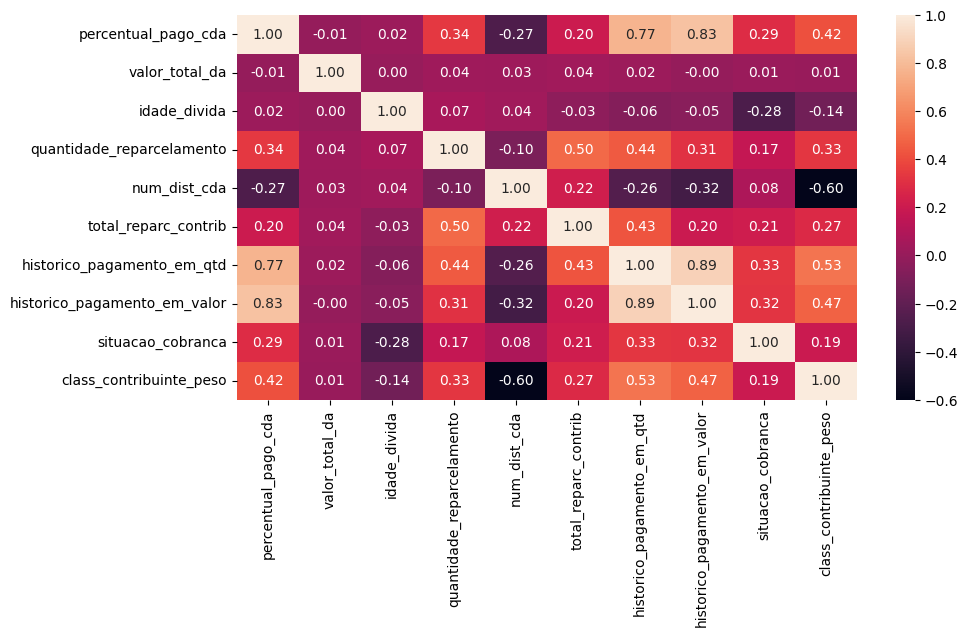

In [49]:
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# 04) Definindo pipeline de treinamento dos modelos

In [50]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [51]:
df_feature_store['percentual_pago_cda'].mean()

0.13768356515230917

In [52]:
y = df_feature_store['percentual_pago_cda']
x = df_feature_store.drop(columns=['percentual_pago_cda'])

In [53]:
x = x.drop(columns = ['tipo_divida', 'percentual_pago_cda_faixas'])#['tipo_tributo_da'].unique()

In [54]:
x.columns

Index(['valor_total_da', 'idade_divida', 'quantidade_reparcelamento',
       'num_dist_cda', 'total_reparc_contrib', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'situacao_cobranca',
       'class_contribuinte_peso'],
      dtype='object')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=0.3)

O CCC é uma métrica que avalia a concordância entre as previsões do modelo e os valores reais,
avalia a consistência das previsões

In [56]:
def ccc_score(y_true, y_pred):
    rho = np.corrcoef(y_true, y_pred)[0, 1] # calcula o coeficiente de pearson entre valores reais e os valores preditos/ 0 e 1 acessa a matriz
    std_true = np.std(y_true)               # calcula o desvio padrao dos valores reais
    std_pred = np.std(y_pred)               # calcula o desvio padrão das previsões do modelo 
    mean_true = np.mean(y_true)             # calcula a média dos valores reais
    mean_pred = np.mean(y_pred)             # calcula a média das previsões do modelo
    
    # fórmula do índice de concordância de Lin
    # O índice de concordância de Lin avalia a concordância entre as previsões do modelo (y_pred) e os valores reais (y_true)
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

In [57]:
def roda_pipeline(algoritimo_normalizador, algoritimo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritimo_normalizador), ('regressor', algoritimo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = mean_squared_error(y_test, previsoes)
    ccc = ccc_score(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritimo_regressao))
    print("R2 ->", r2)
    print("MSE ->", mse)
    print("CCC ->", ccc)

In [58]:
biblioteca_modelos = {
    'dummy': DummyRegressor(), # Dados dummy - Usado para baseline
    'random_forest': RandomForestRegressor(random_state=seed)
}

pipeline_modelos = ['dummy','random_forest']

# 05) Executando o experimento de treinamento do modelo

In [59]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= StandardScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.702955361286399e-07
MSE -> 0.10138177966146705
CCC -> 9.593355574638217e-32

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.8378965743564386
MSE -> 0.016434324408542707
CCC -> 0.9117785895629499


In [60]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= RobustScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -5.702955361286399e-07
MSE -> 0.10138177966146705
CCC -> 9.593355574638217e-32

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.8378441749065809
MSE -> 0.016439636754992944
CCC -> 0.9117482406159866


**Conclusão:** 
- Adotar o algoritmo normalizador de dados StandardScaler

# 06) Realizando previsões com o melhor modelo

In [61]:
normalizador = StandardScaler() 
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)

colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [62]:
x_norm = df_normalizado

In [63]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, random_state=seed, test_size=0.3)

In [64]:
best_model = RandomForestRegressor(random_state=seed)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [65]:
predict_test = best_model.predict(X_test)

r2 = r2_score(y_test, predict_test)
mse = mean_squared_error(y_test, predict_test)
ccc = ccc_score(y_test, predict_test)

print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("MSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.8378316081731818
MSE -> 0.016440910792062904
CCC -> 0.9117489579842025


In [66]:
best_model.get_params() # Parâmetros utilizados

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1337,
 'verbose': 0,
 'warm_start': False}

# RESUMO DE DESEMPENHO DO MODELO DE REGRESSÃO

- R² (R-squared):

Valor Obtido: 0.8379

O R² quantifica o quão bem as variáveis independentes explicam a variação na variável dependente (Target) do modelo.
0.8379 indica que aproximadamente 83.79% da variabilidade na variável de resposta é explicada pelas variáveis independentes
o modelo está capturando uma quantidade significativa da variação nos dados.

- MSE (Erro Quadrático Médio):

Valor Obtido: 0.0164

O MSE mede a média dos erros quadrados entre as previsões do modelo e os valores reais. É uma medida de quão distantes estão as previsões do modelo em relação aos valores reais.
0.0164 é uma métrica de erro bastante baixa. Quanto mais próxima de zero, melhor. 
O modelo está fazendo previsões precisas, com erros médios pequenos.

- CCC (Índice de Concordância de Lin):

Valor Obtido: 0.9118
O CCC é uma métrica que avalia a concordância entre as previsões do modelo e os valores reais. Varia de -1 a 1, onde 1 indica uma concordância perfeita.
É útil para medir a consistência das previsões 
0.9118 é um valor muito próximo de 1, o que sugere uma concordância excelente entre as previsões do seu modelo e valores reais. 
O modelo está fazendo previsões precisas, com uma excelente consistência e assertividade.

# Conclusão
Em síntese, com base nessas métricas, o modelo parece estar funcionando muito bem. Ele explica uma alta proporção da variação nos dados, tem um erro médio quadrático baixo e uma excelente concordância com os valores reais. 
Esses resultados indicam o modelo de regressão está se saindo muito bem na tarefa de previsão.

---

In [67]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['valor_total_da' 'idade_divida' 'quantidade_reparcelamento'
 'num_dist_cda' 'total_reparc_contrib' 'historico_pagamento_em_qtd'
 'historico_pagamento_em_valor' 'situacao_cobranca'
 'class_contribuinte_peso']


In [68]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,historico_pagamento_em_valor,0.670990
1,historico_pagamento_em_qtd,0.110171
2,valor_total_da,0.081584
3,idade_divida,0.040455
4,quantidade_reparcelamento,0.038037
5,total_reparc_contrib,0.023587
6,num_dist_cda,0.021285
7,situacao_cobranca,0.007967
8,class_contribuinte_peso,0.005923


In [69]:
# Realizando predições para avaliações do modelo

previsoes_norm = best_model.predict(x_norm)

In [70]:
# Gerando resíduos da predição (observado - previsão)
df_feature_store['y_predict'] = previsoes_norm
df_feature_store['residuos'] =  df_feature_store['percentual_pago_cda'] - df_feature_store['y_predict']

In [71]:
df_feature_store['percentual_pago_cda'].describe()

count    1.411568e+06
mean     1.376836e-01
std      3.180830e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: percentual_pago_cda, dtype: float64

In [72]:
df_feature_store['y_predict'].describe()

count    1.411568e+06
mean     1.383901e-01
std      2.990244e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.499831e-02
max      1.000000e+00
Name: y_predict, dtype: float64

In [73]:
resid = df_feature_store[['y_predict', 'percentual_pago_cda', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['y_predict'] != 0]
resid_not0_not1 = resid_not0[resid_not0['y_predict'] != 1]
resid_not0_not1

,y_predict,percentual_pago_cda,residuos
61955,0.000206,1.0,0.999794
440171,0.000282,1.0,0.999718
1348857,0.000332,1.0,0.999668
702884,0.000335,1.0,0.999665
541689,0.000444,1.0,0.999556
...,...,...,...
657032,0.991373,0.0,-0.991373
66933,0.993580,0.0,-0.993580
2335539,0.994158,0.0,-0.994158
769555,0.996271,0.0,-0.996271


In [74]:
data_percentil = {
    'inf': [-4, -3, -2, -1,  -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2, 3],
    'sup': [-3, -2, -1,  -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2, 3, 4]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil
    

,inf,sup,intervalo
0,-4.00,-3.00,"[-4.0, -3.0)"
1,-3.00,-2.00,"[-3.0, -2.0)"
2,-2.00,-1.00,"[-2.0, -1.0)"
3,-1.00,-0.75,"[-1.0, -0.75)"
4,-0.75,-0.50,"[-0.75, -0.5)"
5,-0.50,-0.25,"[-0.5, -0.25)"
6,-0.25,0.00,"[-0.25, 0.0)"
7,0.00,0.25,"[0.0, 0.25)"
8,0.25,0.50,"[0.25, 0.5)"
9,0.50,0.75,"[0.5, 0.75)"


In [ ]:
resid

In [76]:
# Define the bins and labels for groups
igr_bins = [-4, -3, -2, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2, 3, 4]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
df_summary_residuos  

,resid_faixas
resid_faixas,
"[-4.0, -3.0)",0
"[-3.0, -2.0)",0
"[-2.0, -1.0)",0
"[-1.0, -0.75)",739
"[-0.75, -0.5)",2245
"[-0.5, -0.25)",10187
"[-0.25, 0.0)",331997
"[0.0, 0.25)",1047356
"[0.25, 0.5)",13794


In [77]:
#df_summary_residuos = resid.groupby('y_faixas')['y_faixas'].count().to_frame()#.reset_index()
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq
0,"[-4.0, -3.0)",0
1,"[-3.0, -2.0)",0
2,"[-2.0, -1.0)",0
3,"[-1.0, -0.75)",739
4,"[-0.75, -0.5)",2245
5,"[-0.5, -0.25)",10187
6,"[-0.25, 0.0)",331997
7,"[0.0, 0.25)",1047356
8,"[0.25, 0.5)",13794
9,"[0.5, 0.75)",2977


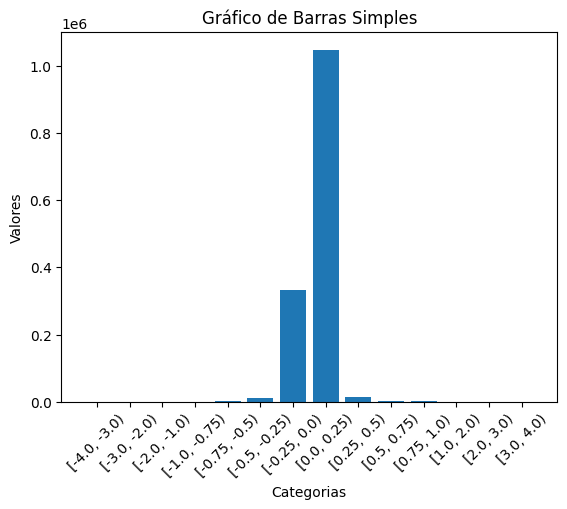

In [78]:
# import matplotlib.pyplot as plt

# # Dados para o gráfico de barras
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']

# # Criar o gráfico de barras
plt.bar(categorias, valores)

# # Adicionar rótulos ao gráfico
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')

plt.xticks(rotation=45)

# # Exibir o gráfico
plt.show()

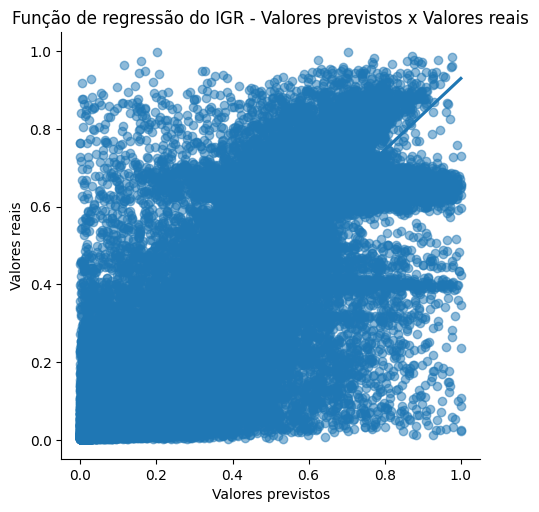

In [79]:
# Todos os pontos
df_regressao = df_feature_store.query("percentual_pago_cda != 1").query("percentual_pago_cda != 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [ ]:
# Residuos entre -0.25 e 0
df_regressao = resid.query("residuos > -0.25").query("residuos <= 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [ ]:
# Residuos entre 0 e 0.25
df_regressao = resid.query("residuos > 0").query("residuos <= 0.25")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [ ]:
# Residuos entre 0.25 e 0.5
df_regressao = resid.query("residuos > 0.25").query("residuos <= 0.5")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [ ]:
# Residuos entre 0.5 e 0.75
df_regressao = resid.query("residuos > 0.5").query("residuos <= 0.75")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [ ]:
# Residuos -1
df_regressao = resid.query("residuos == 1")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [ ]:
resid['residuos'].std()

In [ ]:
# Amostras
df_regressao = resid.sample(n=140000)

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()


# Atenção, Larissa

### Calcular um tamanho de amostra n para amostrar os resíduos

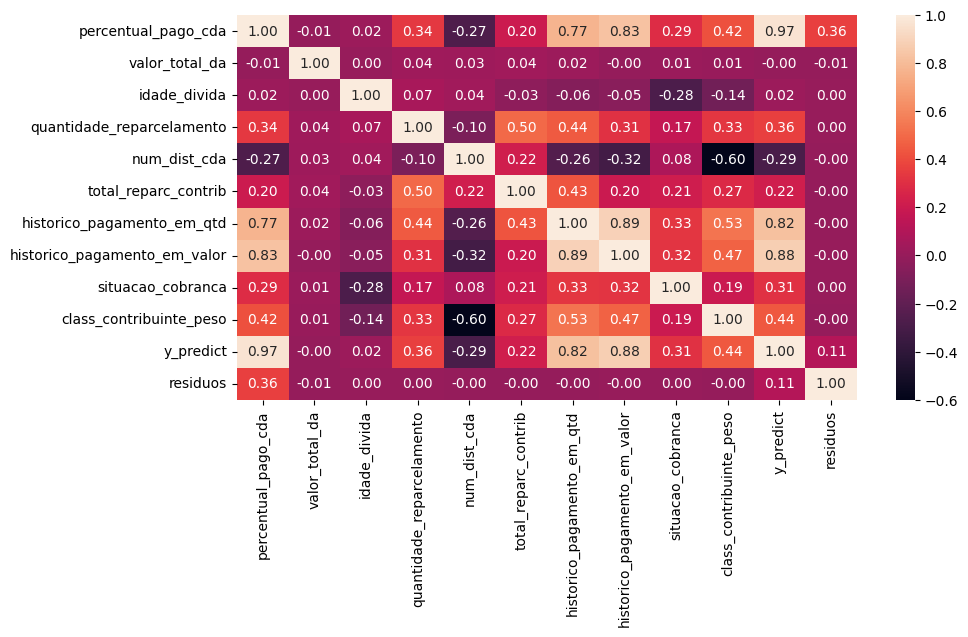

In [80]:
matriz_corr_regressao = df_feature_store.corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_corr_regressao, annot = True, fmt = ".2f")
plt.show()

In [81]:
df_feature_store['residuos'].describe()

count    1.411568e+06
mean    -7.065507e-04
std      8.080979e-02
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: residuos, dtype: float64

In [82]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']

resid['ypred_faixas'] = pd.cut(resid['y_predict'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)
                            
resid['y_faixas'] = pd.cut(resid['percentual_pago_cda'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
contingency_table = pd.crosstab(resid['y_faixas'], resid['ypred_faixas'])
contingency_table   

ypred_faixas,"[0.0, 0.01)","[0.01, 0.25)","[0.25, 0.5)","[0.5, 0.75)","[0.75, 0.99)","[0.99, 1.0)","[1.0, 1.01)"
y_faixas,,,,,,,
"[0.0, 0.01)",963558,122060,7298,1717,659,15,16
"[0.01, 0.25)",2288,82683,8073,803,180,1,5
"[0.25, 0.5)",55,3878,26462,4016,420,6,2
"[0.5, 0.75)",8,412,4383,31365,2530,7,6
"[0.75, 0.99)",7,108,242,1448,560,1,0
"[0.99, 1.0)",0,1,0,1,0,0,0
"[1.0, 1.01)",86,2141,2709,11826,52019,6270,71243


# 07) Salvando o melhor modelo

In [83]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [84]:
salva_modelo_serializado("modeloDA-igr-divida-v2.pkl", best_model)